<a href="https://colab.research.google.com/github/adalves-ufabc/2021.QS-PLN/blob/main/2021_Q1_PLN_Notebook_35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Processamento de Linguagem Natural [2021.Q1]**
Prof. Alexandre Donizeti Alves

### **Reconhecimento de Entidades Nomeadas** 
----

No notebook anterior, usamos modelos pré-treinados para fazer o reconhecimento de entidades nomeadas. Esses modelos pré-treinados são simples de usar, mas eles podem falhar em obter bons resultados se os dados diferem de alguma maneira do tipo de dados usado para o treinamento. Para melhorar o desemepnho em tarefas fora daquele domínio usado para o treinamento, podemos refinar esses modelos treinando em novos dados. O próprio `spaCy` permite que isso seja feito, permitindo tanto treinar um modelo a partir do zero, ou refinar um modelo pré-treinando, incorporando novos elementos.

### **Um exemplo**

No final do notebook anterior, usamos o modelo de reconhecimento de entidades nomeadas do `spaCy` para reconhecer entidades em uma notícia sobre a desistência de compra da Embraer pela Boeing. Como pôde ser observado, o modelo reconheceu a Boeing como uma empresa, mas o termo Embraer foi reconhecido como pessoa, localização e como organização. Isso se deve ao fato de Embraer não ocorrer no corpus em que o modelo foi treinado. 

Vamos reaplicar o modelo a um trecho daquela notícia:

In [1]:
import spacy
from spacy import displacy

# precisa fazer download do modelo com o comando
# !python -m spacy download en
import en_core_web_sm
nlp = en_core_web_sm.load()

In [2]:
text = """Walking away from the deal will help Boeing conserve cash at a time when it is facing a litany of 
          problems. The spread of the coronavirus forced the aerospace giant to temporarily close factories, 
          although it has reopened some of them. And a steep drop in travel has prompted airlines around the 
          world to cancel orders. Boeing said it had decided to end two years of talks with Embraer, 
          a Brazilian plane maker, after a Friday night deadline passed without Embraer meeting certain 
          conditions, which Boeing would not specify."""

In [3]:
sent = nlp(text)
displacy.render(sent, jupyter=True, style='ent')

Nesse trecho, Embraer é reconhecido duas vezes como localização (GPE). Podemos corrigir isso dando ao modelo mais dados de treinamento. Obviamente, não iremos fornecer a mesma sentença acima para evitar um ajuste específico para essa sentença (*overfitting* - sobreajuste ou superajuste). Ao contrário, vamos usar sentenças que mencionam essa entidade alvo. 

Foram selecionadas três frases que mencionam Embraer (https://en.wikipedia.org/wiki/Embraer), e anotadas com o rótulo da entidade. A rotulação segue o esquema BILUO, que coloca no início do rótulo o termo "B-" (Begin - início),  "I-" (Inside - dentro), "L-" (Last - último), "U-" (Unit - unitário), "O-" (Out - fora), para tokens no início, dentro, último, unitário e fora de uma entidade, respectivamente. 

>

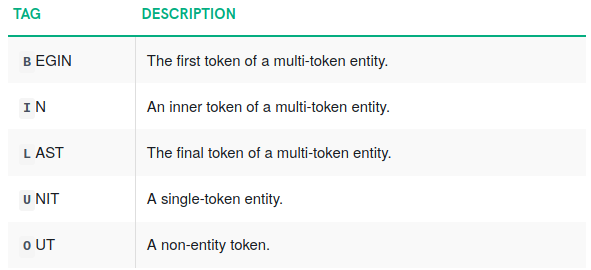


As três sentenças selecionadas e anotadas são listadas a seguir:


In [5]:
training_texts = [
   (["Embraer", "S.A.", "is", "a",  "Brazilian",  "aerospace", "conglomerate", "that", "produces", "commercial", 
    "military", "executive", "and", "agricultural", "aircraft", "and", "provides", "aeronautical", "services"],
    ["B-ORG", "L-ORG", "O", "O",  "U-NORP",  "O", "O", "O", "O", "O", "O",
     "O", "O", "O", "O", "O", "O", "O", "O"]),
   (["The", "Brazilian", "government", "contributed", "to", "Embraer", "'s", "early", "growth", "by", 
     "providing", "production", "contracts"],
    ["O", "U-NORP", "O", "O", "O", "U-ORG", "O", "O", "O", "O", "O", "O", "O"]),
   (["While", "military", "aircraft", "made", "up", "the", "majority", "of", "Embraer", "'s",
     "products", "during", "the", "1970s", "and", "early", "1980s"],
    ["O", "O", "O", "O", "O", "O", "O", "O", "U-ORG", "O",
     "O", "O", "O", "U-DATE", "O", "O", "U-DATE"])]

Para cada uma dessas sentenças, vamos criar um objeto *`document`* do `spaCy`, e adicionar ao modelo que estamos usando. As sentenças já estão tokenizadas, então não é necessário efetuar essa tarefa. Os tokens desse documento com os rótulos corretos são unidos em um objeto do tipo `GoldParse` (em alusão ao "padrão ouro", usado na medicina para designar o exame usado como referência para diagnosticar uma doença). 

In [6]:
from spacy.tokens import Doc
from spacy.gold import GoldParse

training_data = []
for tokens, annotation in training_texts:
    doc = Doc(nlp.vocab, words=tokens)
    gold = GoldParse(doc, entities=annotation)
    training_data.append((doc, gold))

Podemos agora fazer o treinamento. Isso significa que o modelo que estamos usando irá acessar o conjunto de dados de treinamento, de preferência várias vezes. Cada etapa é chamada de uma **época**, e para melhorar a convergência, em cada época fazemos um embaralhamento dos dados de treinamento. No exemplo, o processo é repetido 10 vezes.


In [7]:
import random

for _ in range(10):
    random.shuffle(training_data)
    for doc, gold in training_data:
        nlp.update([doc], [gold], drop=0.3)

Vamos agora repetir o processo de identificação das entidades, com o modelo refinado. A saída mostra que a entidade Embraer é corretamente reconhecida como uma organização.

In [8]:
sent = nlp(text)
displacy.render(sent, jupyter=True, style='ent')

### **Outro exemplo**

In [8]:
from IPython.display import HTML, display
import tabulate
import spacy

nlp = spacy.load("en")
text = "Theresa May is a British politician serving as Prime Minister of the United Kingdom and Leader of the Conservative Party since 2016. "

doc = nlp(text)
entities = [(t.text, t.ent_iob_, t.ent_type_) for t in doc]
display(HTML(tabulate.tabulate(entities, tablefmt='html')))

Theresa,B,PERSON
May,I,PERSON
is,O,
a,O,
British,B,NORP
politician,O,
serving,O,
as,O,
Prime,O,
Minister,O,
of,O,


`spaCy` reconhece com sucesso *British* como uma nacionalidade (NORP), *United Kingdom* como uma entidade geopolítica (GPE), *Conservative Party* como uma organização (ORG) e 2016 como uma data. Além disso, reconhece "Theresa May" como uma pessoa. **Antes, o `spaCy` rotulava "Theresa" como uma organização e "May" como uma data.**

### **Refinando um modelo com um corpus pré-rotulado**

No entanto, na prática, precisamos de muito mais do que três exemplos. Se tivermos um corpus maior já rotulado, podemos refinar um modelo para uma tarefa específica. Por exemplo, podemos usar uma base de dados de currículos previamente rotulada com profissão, conhecimentos e cursos, ou prontuários médicos que já foram rotulados com sintomas e doenças etc., e usar esses dados para treinar um modelo de reconhecimento de entidades para extrair informações de milhares de documentos não rotulados.

Como exemplo, vamos treinar um reconhecedor de entidades nomeadas em dados em Holandês, que foram coletados para uma competição chamada [CoNLL-2002](https://www.clips.uantwerpen.be/conll2002/ner/). 

Esses dados podem ser baixados do GitHub. Vamos usar o comando `curl` para baixar. Caso não tenha em seu sistema, pode baixar diretamente a partir do GitHub. 

In [9]:
!curl -O https://raw.githubusercontent.com/teropa/nlp/master/resources/corpora/conll2002/ned.train

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2321k  100 2321k    0     0  6847k      0 --:--:-- --:--:-- --:--:-- 6847k


In [10]:
!curl -O https://raw.githubusercontent.com/teropa/nlp/master/resources/corpora/conll2002/ned.testa 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  440k  100  440k    0     0  1991k      0 --:--:-- --:--:-- --:--:-- 1982k


In [11]:
!curl -O https://raw.githubusercontent.com/teropa/nlp/master/resources/corpora/conll2002/ned.testb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  795k  100  795k    0     0  2624k      0 --:--:-- --:--:-- --:--:-- 2624k


São três arquivos: um de treino, um de validação e um de teste. Nesses arquivos, cada linha no conjunto de texto contém um token, e sentenças são separadas por linhas vazias. Cada token consiste em campos separados por tabs. No nosso caso, estamos interessados no token (primeiro campo) e a sua entidade (último campo).

O trecho a seguir faz a leitura desses arquivos, e extrai essas duas colunas:

In [12]:
from operator import itemgetter

train_file = "ned.train"
dev_file = "ned.testa"
test_file = "ned.testb"

def read_conll_file(f):
    data = []
    with open(f) as i:
        sentences = i.read().strip().split("\n\n")
        
    for sentence in sentences:
        data.append([token.split() for token in sentence.split("\n")])

    return data
        
train_data = read_conll_file(train_file)
dev_data = read_conll_file(dev_file)
test_data = read_conll_file(test_file)

A função a seguir avalia a qualidade de um modelo em um desses conjuntos. O que ela faz é, basicamente, montar as sentenças a  partir da base, aplicar o modelo de reconhecimento de entidades nomeadas, e comparar as entidades classificadas com o rótulo verdadeiro.

In [13]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

def evaluate(model, data, verbose=0): 

    ner = model.get_pipe("ner")
    
    correct, predicted = [], []
    for sentence in data:
        tokens = [t[0] for t in sentence]
        ent_labels = [t[2].split("-")[-1] for t in sentence]
        
        doc = Doc(model.vocab, words=tokens)
        ner(doc)
        
        pred_labels = [t.ent_type_ or "O" for t in doc]
        correct += ent_labels
        predicted += pred_labels
        
    if verbose:
        print(classification_report(correct, predicted))
    
    return precision_recall_fscore_support(correct, predicted, average="micro")

Podemos comparar o modelo padrão do `spaCy` para holandês.

In [14]:
import spacy

!python -m spacy download nl_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('nl_core_news_sm')


In [15]:
import nl_core_news_sm

nlp = spacy.load("nl_core_news_sm")

In [16]:
evaluate(nlp, test_data, verbose=1);

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    CARDINAL       0.00      0.00      0.00         0
        DATE       0.00      0.00      0.00         0
       EVENT       0.00      0.00      0.00         0
         FAC       0.00      0.00      0.00         0
         GPE       0.00      0.00      0.00         0
    LANGUAGE       0.00      0.00      0.00         0
         LAW       0.00      0.00      0.00         0
         LOC       0.22      0.02      0.04       823
        MISC       0.00      0.00      0.00      1597
       MONEY       0.00      0.00      0.00         0
        NORP       0.00      0.00      0.00         0
           O       0.98      0.91      0.94     63236
     ORDINAL       0.00      0.00      0.00         0
         ORG       0.48      0.31      0.37      1433
         PER       0.00      0.00      0.00      1905
     PERCENT       0.00      0.00      0.00         0
      PERSON       0.00      0.00      0.00         0
     PRODUCT       0.00    

Como pode ser observado, o modelo consegue classificar corretamente apenas algumas organizações (ORG) e lugares (LOC), além daqueles termos que não são entidades (O). A função a seguir prepara o conjunto de treinamento para essa base de dados (incluindo a representação no formato BILUO). 

In [17]:
from spacy.gold import iob_to_biluo

training_data = []
for sentence in train_data:
    tokens = [t[0] for t in sentence]
    ent_labels = iob_to_biluo([t[2] for t in sentence])
    doc = Doc(nlp.vocab, words=tokens)
    gold = GoldParse(doc, entities=ent_labels)
    training_data.append((doc, gold))

Podemos agora comparar duas situações diferentes: primeiramente, treinar um modelo `spaCy` a partir do zero. Isso pode ser feito criando um modelo "em branco", e adicionando um reconhecedor de entidades nomeadas, e fazer o treinamento. 

No segundo caso, o  modelo é treinado aproveitando um modelo já existente, e continuamos o treinamento com novos dados (como fizemos no reconhecedor da Embraer). 

Fora a inicialização, o treinamento desses dois modelos é muito parecido. Para fins de reduzir o custo computacional, o modelo  só será capaz de reconhecer entidades nomeadas. O treinamento é feito em até 100 épocas, mas o processo pode ser terminado se as métricas de desempenho não melhorarem, usando o conjunto de validação para avaliar o desempenho.

O método a seguir faz o treinamento:

In [18]:
from tqdm import tqdm
from spacy.util import minibatch
from pathlib import Path

def train(train_docs, dev_data, output_dir, model=None, max_epochs=100): 
    
    if not model: 
        model = spacy.blank("nl")
        ner = model.create_pipe("ner")
        model.add_pipe(ner, last=True)
        for label in ["PER", "LOC", "ORG", "MISC"]: 
            ner.add_label(label)
        model.begin_training()
    else:
        ner = model.get_pipe("ner")
        for label in ["PER", "MISC"]: 
            ner.add_label(label)
        
    other_pipes = [pipe for pipe in model.pipe_names if pipe != 'ner']
    fscore_history = []
    patience=3
        
    with model.disable_pipes(*other_pipes):
    
        for i in range(max_epochs):
            print("Epoch", i)
            losses = {}
            random.shuffle(train_docs)
            batches = minibatch(train_docs, size=32)
            for batch in tqdm(batches):
                docs, golds = zip(*batch)
                model.update(
                    docs,
                    golds,
                    drop=0.4,
                    losses=losses)
            print("Training Loss:", losses)
            
            _, _, dev_f, _ = evaluate(model, dev_data)
            print("Development F-score:", dev_f)
            
            if len(fscore_history) > 0 and dev_f > max(fscore_history): 
                if output_dir is not None:
                    output_dir = Path(output_dir)
                    if not output_dir.exists():
                        output_dir.mkdir()
                    model.to_disk(output_dir)
                    print("Saved model to", output_dir)
            
            fscore_history.append(dev_f)
            
            if max(fscore_history) > max(fscore_history[-patience:]):
                print("No improvement on development set. Stop training.")
                break

In [19]:
output_dir_scratch = "./spacy_ner_scratch"
train(training_data, dev_data, model=None, output_dir=output_dir_scratch)

2it [00:00, 11.56it/s]

Epoch 0


494it [00:39, 12.63it/s]


Training Loss: {'ner': 16465.02497434501}


2it [00:00, 13.22it/s]

Development F-score: 0.9488361007388576
Epoch 1


494it [00:39, 12.66it/s]


Training Loss: {'ner': 10228.20644837401}


0it [00:00, ?it/s]

Development F-score: 0.9576547231270358
Saved model to spacy_ner_scratch
Epoch 2


494it [00:38, 12.83it/s]


Training Loss: {'ner': 8347.379129985344}


0it [00:00, ?it/s]

Development F-score: 0.9608855697677497
Saved model to spacy_ner_scratch
Epoch 3


494it [00:38, 12.78it/s]


Training Loss: {'ner': 7080.161054210442}


0it [00:00, ?it/s]

Development F-score: 0.9655464632822224
Saved model to spacy_ner_scratch
Epoch 4


494it [00:38, 12.84it/s]


Training Loss: {'ner': 6163.892902246062}


0it [00:00, ?it/s]

Development F-score: 0.9667911337093827
Saved model to spacy_ner_scratch
Epoch 5


494it [00:38, 12.78it/s]


Training Loss: {'ner': 5393.870682467941}


0it [00:00, ?it/s]

Development F-score: 0.9681682158841133
Saved model to spacy_ner_scratch
Epoch 6


494it [00:38, 12.87it/s]


Training Loss: {'ner': 4877.2933145809175}


0it [00:00, ?it/s]

Development F-score: 0.9684595217287678
Saved model to spacy_ner_scratch
Epoch 7


494it [00:38, 12.89it/s]


Training Loss: {'ner': 4476.203443216009}


0it [00:00, ?it/s]

Development F-score: 0.9686448981753661
Saved model to spacy_ner_scratch
Epoch 8


494it [00:38, 12.95it/s]


Training Loss: {'ner': 4087.9897031437754}


0it [00:00, ?it/s]

Development F-score: 0.9698366039034984
Saved model to spacy_ner_scratch
Epoch 9


494it [00:37, 13.06it/s]


Training Loss: {'ner': 3797.7664271783833}


2it [00:00, 13.67it/s]

Development F-score: 0.9693864039617595
Epoch 10


494it [00:38, 12.82it/s]


Training Loss: {'ner': 3605.9691549444324}


2it [00:00, 13.31it/s]

Development F-score: 0.9681682158841133
Epoch 11


494it [00:38, 12.67it/s]


Training Loss: {'ner': 3278.3616363535957}
Development F-score: 0.9689891687190487
No improvement on development set. Stop training.


Vamos agora continuar o treinamento do modelo base.

In [20]:
output_dir_cntd = "./spacy_ner_cntd"
train(training_data, dev_data, model=nlp, output_dir=output_dir_cntd)

2it [00:00, 12.38it/s]

Epoch 0


494it [00:41, 12.05it/s]


Training Loss: {'ner': 115381.56111907959}


2it [00:00, 13.23it/s]

Development F-score: 0.9492333359815683
Epoch 1


494it [00:40, 12.09it/s]


Training Loss: {'ner': 109836.78122901917}


0it [00:00, ?it/s]

Development F-score: 0.957231005534811
Saved model to spacy_ner_cntd
Epoch 2


494it [00:39, 12.38it/s]


Training Loss: {'ner': 108374.48465919495}


0it [00:00, ?it/s]

Development F-score: 0.9577341701755779
Saved model to spacy_ner_cntd
Epoch 3


494it [00:39, 12.60it/s]


Training Loss: {'ner': 108188.47304534912}


0it [00:00, ?it/s]

Development F-score: 0.9605412992240672
Saved model to spacy_ner_cntd
Epoch 4


494it [00:39, 12.64it/s]


Training Loss: {'ner': 108033.39396095276}


0it [00:00, ?it/s]

Development F-score: 0.9612563226609465
Saved model to spacy_ner_cntd
Epoch 5


494it [00:38, 12.80it/s]


Training Loss: {'ner': 107699.0710849762}


0it [00:00, ?it/s]

Development F-score: 0.9633484282725563
Saved model to spacy_ner_cntd
Epoch 6


494it [00:38, 12.80it/s]


Training Loss: {'ner': 107212.66063404083}


2it [00:00, 13.05it/s]

Development F-score: 0.963163051825958
Epoch 7


494it [00:39, 12.61it/s]


Training Loss: {'ner': 106881.76384735107}


0it [00:00, ?it/s]

Development F-score: 0.9641164164084638
Saved model to spacy_ner_cntd
Epoch 8


494it [00:39, 12.44it/s]


Training Loss: {'ner': 106697.10493659973}


0it [00:00, ?it/s]

Development F-score: 0.9651492280395116
Saved model to spacy_ner_cntd
Epoch 9


494it [00:41, 12.03it/s]


Training Loss: {'ner': 106264.41773986816}


2it [00:00, 12.99it/s]

Development F-score: 0.963745663515267
Epoch 10


494it [00:41, 11.99it/s]


Training Loss: {'ner': 106409.9300403595}


2it [00:00, 11.99it/s]

Development F-score: 0.9638780752628374
Epoch 11


494it [00:42, 11.73it/s]


Training Loss: {'ner': 106791.24457740784}
Development F-score: 0.9635338047191547
No improvement on development set. Stop training.


Podemos agora comparar os três modelos no conjunto de teste.

In [21]:
nlp_base = spacy.load("nl_core_news_sm")
nlp_scratch = spacy.load(output_dir_scratch)
nlp_cntd = spacy.load(output_dir_cntd)

print("\n********** Base Model **********")
evaluate(nlp_base, test_data, verbose=1)
print("\n********** New Model **********")
evaluate(nlp_scratch, test_data, verbose=1)
print("\n********** Continued Model **********")
evaluate(nlp_cntd, test_data, verbose=1)


********** Base Model **********


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    CARDINAL       0.00      0.00      0.00         0
        DATE       0.00      0.00      0.00         0
       EVENT       0.00      0.00      0.00         0
         FAC       0.00      0.00      0.00         0
         GPE       0.00      0.00      0.00         0
    LANGUAGE       0.00      0.00      0.00         0
         LAW       0.00      0.00      0.00         0
         LOC       0.22      0.02      0.04       823
        MISC       0.00      0.00      0.00      1597
       MONEY       0.00      0.00      0.00         0
        NORP       0.00      0.00      0.00         0
           O       0.98      0.91      0.94     63236
     ORDINAL       0.00      0.00      0.00         0
         ORG       0.48      0.31      0.37      1433
         PER       0.00      0.00      0.00      1905
     PERCENT       0.00      0.00      0.00         0
      PERSON       0.00      0.00      0.00         0
     PRODUCT       0.00    

(0.9732585442212366, 0.9732585442212366, 0.9732585442212366, None)

**Importante**: algumas partes dos dados de treinamento são aleatórias, como por exemplo, a ordem em que alimentamos os dados para o modelo.

### **Algumas considerações**

Infelizmente, o treinamento contínuo de um modelo pré-treinado tem seus desafios. E o mais importante, você precisa se certificar de que seu modelo não se ajuste demais aos novos dados de treinamento e perca a capacidade de rotular o tipo de dados em que foi originalmente treinado. Ainda assim, quando você acerta, o ajuste fino de um modelo existente é uma maneira poderosa de treinar um modelo de alta qualidade com uma quantidade limitada de dados.

**Referência**:

Este notebook foi criado pelo prof. **Ronaldo Prati** [UFABC], tendo sido apenas reestruturado por mim. O prof. Ronaldo se baseou no seguinte [exemplo](https://github.com/nlptown/nlp-notebooks/blob/master/Updating%20spaCy's%20Named%20Entity%20Recognition%20System.ipynb).
